#Regression Trees#

Baseball player salary data:

- *Years*; x axis
- *Hits*; y-axis
- *Salary*; color

Group exercise:
- Want to maximize similarity within regions
- Generally add horizontal/vertical lines in non-integer values so that model doesn't have to decide, for example, which region a test data point should go if it equals 5 and a boundary is at 5

Reading trees:
- True (go left)
- False (go right)
- Splits labeled by rule
- Bottom is labeled by mean of that region (in example for some reason it's dividied by 1000 and log transformed)
- The first split you make is the most "important" variable
    - For a player with a lower number of Years, Hits is not an important factor determining Salary
    - For a player with a higher number of Years, Hits is an important factor determining Salary
- Decision tree can learn nonlinear relationships

###How does a computer build a regression tree?###

**Recursive binary splitting**
1. For every feature, evaluate the MSE of each cutpoint. Pick the feature and its cutpoint with the lowest MSE.
2. Evaluate again using MSE on the regions created by the split.
3. When do you stop? Either:
    - a max tree depth
    - minimum number of observations in a leaf

In [30]:
import pandas as pd
url = 'https://raw.githubusercontent.com/justmarkham/DAT7/master/data/vehicles_train.csv'
train = pd.read_csv(url)

# before splitting anything, just predict the mean of the entire dataset
# null model
train['prediction'] = train.price.mean()
train

,price,year,miles,doors,vtype,prediction
0,22000,2012,13000,2,car,6571.428571
1,14000,2010,30000,2,car,6571.428571
2,13000,2010,73500,4,car,6571.428571
3,9500,2009,78000,4,car,6571.428571
4,9000,2007,47000,4,car,6571.428571
5,4000,2006,124000,2,car,6571.428571
6,3000,2004,177000,4,car,6571.428571
7,2000,2004,209000,4,truck,6571.428571
8,3000,2003,138000,2,car,6571.428571
9,1900,2003,160000,4,car,6571.428571


In [31]:
# RMSE of null model
from sklearn import metrics
import numpy as np
np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

5936.9819859959835

In [32]:
# splitting function on miles
def mileage_split(miles):
    lower_mileage_price = train[train.miles < miles].price.mean()
    higher_mileage_price = train[train.miles >= miles].price.mean()
    train['prediction'] = np.where(train.miles < miles, lower_mileage_price, higher_mileage_price)
    return np.sqrt(metrics.mean_squared_error(train.price, train.prediction))

In [33]:
mileage_split(50000)

3984.0917425414564

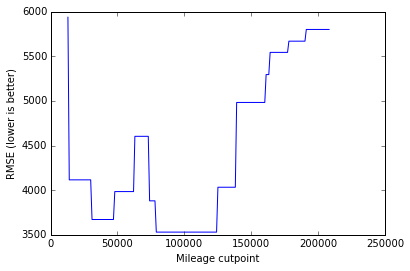

In [34]:
# check all possible mileage splits
mileage_range = range(train.miles.min(), train.miles.max(), 1000)
RMSE = [mileage_split(miles) for miles in mileage_range]

# plot mileage cutpoint (x-axis) versus RMSE (y-axis)
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(mileage_range, RMSE)
plt.xlabel('Mileage cutpoint')
plt.ylabel('RMSE (lower is better)')

###Building a regression tree in scikit-learn###

In [35]:
# car = 0, truck = 1
train['vtype'] = train.vtype.map({'car':0, 'truck':1})

In [36]:
# X and y
feature_cols = ['year', 'miles', 'doors', 'vtype']

X = train[feature_cols]
y = train.price

In [37]:
from sklearn.tree import DecisionTreeRegressor # or DecisionTreeClassifier depending on your dependent variable
treereg = DecisionTreeRegressor(random_state = 1)
treereg
# max_depth = None; by default, there's no limit
# min_leaf = 1; by default, it will grow the tree until there is one leaf in every bucket (unless another criterion is used)

DecisionTreeRegressor(compute_importances=None, criterion='mse',
           max_depth=None, max_features=None, max_leaf_nodes=None,
           min_density=None, min_samples_leaf=1, min_samples_split=2,
           random_state=1, splitter='best')

In [38]:
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')

In [39]:
# RMSE
np.mean(np.sqrt(-scores))

2928.5714285714284

How do we determine depth? Look at cross-validation MSE

**Tree Tuning**

1. Look at max depth
    - Write a loop, similar to checking splits

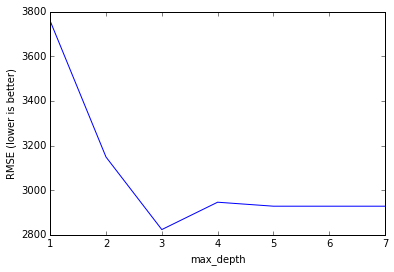

In [40]:
max_depth_range = range(1, 8)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use LOOCV with each value of max_depth
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('RMSE (lower is better)')

In [41]:
# using max depth = 3, fitting on all of your data
treereg = DecisionTreeRegressor(max_depth=3, random_state=1)
treereg.fit(X, y)

DecisionTreeRegressor(compute_importances=None, criterion='mse', max_depth=3,
           max_features=None, max_leaf_nodes=None, min_density=None,
           min_samples_leaf=1, min_samples_split=2, random_state=1,
           splitter='best')

In [42]:
# "Gini importance" of each feature: the (normalized) total reduction of error brought by that feature
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_})

,feature,importance
0,year,0.798744
1,miles,0.201256
2,doors,0.000000
3,vtype,0.000000


###Tree Diagrams###

Check class notes markdown

###Making predictions###

In [44]:
urlt = 'https://raw.githubusercontent.com/justmarkham/DAT7/master/data/vehicles_test.csv'

test = pd.read_csv(urlt)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [45]:
# use fitted model to make predictions on testing data
X_test = test[feature_cols]
y_test = test.price
y_pred = treereg.predict(X_test)

In [46]:
# calculate RMSE
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

1190.2380714238084

In [47]:
# calculate RMSE for own tree
y_pred1 = [2437, 7000, 16333]
np.sqrt(metrics.mean_squared_error(y_test, y_pred1))

2587.9115131704175

#Classification Trees#